In [47]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from itertools import combinations
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, accuracy_score
import xgboost as xgb
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [101]:
def load_dataframes(imputed_file_path, daily_file_path):
    imputed_df = pd.read_csv(imputed_file_path)
    daily_df = pd.read_csv(daily_file_path)
    return imputed_df, daily_df

def create_subdatasets_by_node_id(df: pd.DataFrame)-> dict:
    grouped_data = df.groupby('NodeID')
    subdatasets = {key: group for key, group in grouped_data}
    return subdatasets

def train_test_split(df, num_wells):
    random.seed(42)

    train_node_ids = random.sample(list(df['NodeID'].unique()), num_wells)
    train_data = df[df['NodeID'].isin(train_node_ids)]
    
    test_node_ids = list(set(df['NodeID'].unique()) - set(train_node_ids))
    test_data = df[df['NodeID'].isin(test_node_ids)]
    
    return train_data, test_data

def plot_roc_curve_and_confusion_matrix(y_true, y_pred, ax=None):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4)) 

    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm)
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=axs[0])
    axs[0].set_title('\nConfusion Matrix')
    axs[0].set_xlabel('Predicted')
    axs[0].set_ylabel('Actual')

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    axs[1].plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
    axs[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
    axs[1].set_xlim([0.0, 1.0])
    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlabel('1-Specificity')
    axs[1].set_ylabel('Sensitivity')
    axs[1].set_title('\nReceiver Operating Characteristic (ROC) Curve')
    axs[1].legend(loc="lower right")
    plt.subplots_adjust(wspace=5) 
    plt.tight_layout()
    plt.show()
    return cm

def calculate_metrics_from_confusion_matrix(cm):
    TN, FP = cm[0]
    FN, TP = cm[1]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)

    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
        'Score': [accuracy, precision, recall, f1]
    })

    return metrics_df

In [102]:
imputed_file_path = '..\\data\\interim\\imputed_data.csv'
daily_file_path = '..\\data\\interim\\daily_averaged_data.csv'
imputed_df, daily_df = load_dataframes(imputed_file_path, daily_file_path)

In [105]:
subdatasets = create_subdatasets_by_node_id(daily_df)

In [106]:
modified_datasets_dict = {}

for key, df in subdatasets.items():
    df_copy = df.copy()
    df_copy["Label"] = df_copy["Label"].shift(-5)  
    df_copy["Label"].fillna(1, inplace=True)
    modified_datasets_dict[key] = df_copy

In [110]:
merged_df = pd.concat(modified_datasets_dict.values(), ignore_index=True)
merged_df.head()

merged_df['Label'] = merged_df['Label'].astype(int)

In [111]:
df_train, df_test = train_test_split(merged_df, 10)

df_train.head()

,NodeID,Date,MotorCurrent,Frequency,PIP,TubingPressure,CasingPressure,PIT,MotorTemperature,XVib,Label
0,0,2020-01-10,31.014205,59.032513,596.025884,221.333333,138.740530,247.036301,277.455808,2.108586,0
1,0,2020-01-11,31.035732,58.875316,588.204167,233.916667,135.968434,247.013889,277.169003,2.102694,0
2,0,2020-01-12,31.013889,58.989583,581.595328,231.826389,127.770833,247.000000,277.060922,2.020202,0
3,0,2020-01-13,31.008102,58.996528,575.665509,224.361111,131.902778,247.000000,277.145833,2.027778,0
4,0,2020-01-14,31.035038,59.003472,572.395202,224.000000,118.000000,247.000000,277.340593,1.968434,0


In [112]:
X_train = df_train.drop(['Label', 'NodeID', 'Date'], axis = 1)
y_train = df_train['Label']
X_test = df_test.drop(['Label', 'NodeID', 'Date'], axis = 1)
y_test = df_test['Label']

In [113]:
X_train.head()

,MotorCurrent,Frequency,PIP,TubingPressure,CasingPressure,PIT,MotorTemperature,XVib
0,31.014205,59.032513,596.025884,221.333333,138.740530,247.036301,277.455808,2.108586
1,31.035732,58.875316,588.204167,233.916667,135.968434,247.013889,277.169003,2.102694
2,31.013889,58.989583,581.595328,231.826389,127.770833,247.000000,277.060922,2.020202
3,31.008102,58.996528,575.665509,224.361111,131.902778,247.000000,277.145833,2.027778
4,31.035038,59.003472,572.395202,224.000000,118.000000,247.000000,277.340593,1.968434


In [114]:
X_train.shape

(908, 8)

### $\textbf{Decision Tree}$

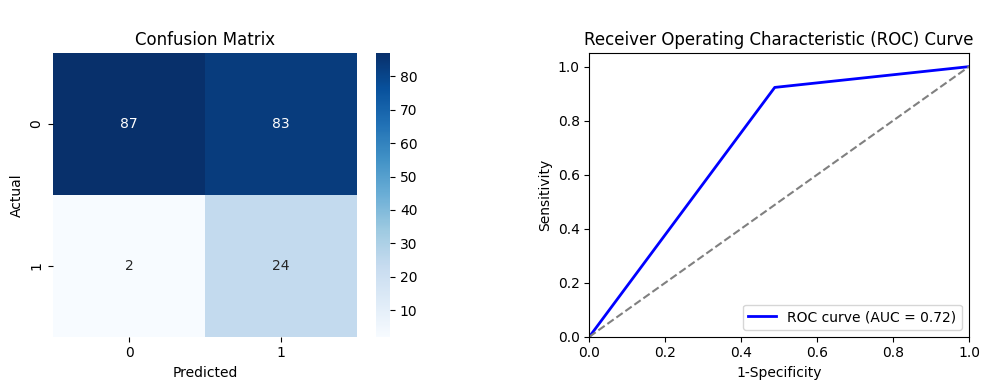

In [171]:
dt_model = DecisionTreeClassifier(random_state=42,
                                  max_depth=7,
                                  min_samples_split=5,
                                  min_samples_leaf=3,
                                  max_features=5,
                                  criterion='gini')

dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
cm = plot_roc_curve_and_confusion_matrix(y_test, y_pred_dt)

In [172]:
calculate_metrics_from_confusion_matrix(cm)

,Metric,Score
0,Accuracy,0.566327
1,Precision,0.224299
2,Recall,0.923077
3,F1-score,0.360902


In [315]:
X_test_with_predictions = X_test.copy()
X_test_with_predictions['True Label'] = y_test
X_test_with_predictions['Predicted Label'] = y_pred_dt

misclassified = X_test_with_predictions[X_test_with_predictions['True Label'] != X_test_with_predictions['Predicted Label']]
print("Misclassified Observations:")
misclassified

Misclassified Observations:


,MotorCurrent,Frequency,PIP,TubingPressure,CasingPressure,PIT,MotorTemperature,XVib,True Label,Predicted Label
422,24.544823,57.997790,361.599747,130.823548,218.729167,237.454861,259.000000,2.461490,0,1
430,25.267677,58.190025,346.111742,137.028409,260.576389,235.351010,256.987689,2.831755,0,1
431,23.411616,57.535038,374.927399,113.162563,192.338384,240.954861,261.754104,2.867424,0,1
432,23.472538,57.599747,392.423611,116.768308,195.341856,240.756313,261.887942,2.794823,0,1
441,23.843750,56.968750,366.614583,121.479167,239.059028,243.079861,263.562500,3.052083,0,1
...,...,...,...,...,...,...,...,...,...,...
696,28.471528,56.078586,970.293371,155.972222,96.484848,260.073864,283.189710,6.333333,0,1
697,28.305240,55.713709,974.141446,152.827652,97.950126,260.883838,284.016098,6.407828,0,1
698,28.431250,55.747986,974.885069,155.840278,96.465278,260.263889,283.121528,6.468750,0,1
705,28.545297,56.000281,969.368845,183.772727,125.027778,258.248422,281.063131,6.506629,1,0


In [319]:
df_test[-15:]

,NodeID,Date,MotorCurrent,Frequency,PIP,TubingPressure,CasingPressure,PIT,MotorTemperature,XVib,Label
697,7,2020-06-12,28.305240,55.713709,974.141446,152.827652,97.950126,260.883838,284.016098,6.407828,0
698,7,2020-06-13,28.431250,55.747986,974.885069,155.840278,96.465278,260.263889,283.121528,6.468750,0
699,7,2020-06-14,28.479072,55.996509,971.512083,154.411237,96.822348,260.690088,283.779040,6.501073,1
700,7,2020-06-15,28.757162,56.428048,970.016379,186.820802,123.011620,259.501804,282.350276,6.532926,1
701,7,2020-06-16,28.317551,56.675436,976.619318,172.302083,124.222538,261.881944,284.590909,6.503472,1
702,7,2020-06-17,28.724653,56.173854,976.470139,179.107639,125.538194,260.180556,282.579861,6.510417,1
703,7,2020-06-18,28.435859,55.917244,971.997254,172.350379,124.560606,260.261995,283.082386,6.440657,1
704,7,2020-06-19,28.427999,56.247822,975.864426,176.130997,125.054293,260.259785,282.453914,6.363321,1
705,7,2020-06-20,28.545297,56.000281,969.368845,183.772727,125.027778,258.248422,281.063131,6.506629,1
706,7,2020-06-21,28.845581,53.606922,958.673706,179.808081,113.785354,248.904356,270.354798,5.211806,1


In [322]:
daily_df[daily_df.NodeID == 7][-15:]

,NodeID,Date,MotorCurrent,Frequency,PIP,TubingPressure,CasingPressure,PIT,MotorTemperature,XVib,Label
697,7,2020-06-12,28.305240,55.713709,974.141446,152.827652,97.950126,260.883838,284.016098,6.407828,0.0
698,7,2020-06-13,28.431250,55.747986,974.885069,155.840278,96.465278,260.263889,283.121528,6.468750,0.0
699,7,2020-06-14,28.479072,55.996509,971.512083,154.411237,96.822348,260.690088,283.779040,6.501073,0.0
700,7,2020-06-15,28.757162,56.428048,970.016379,186.820802,123.011620,259.501804,282.350276,6.532926,0.0
701,7,2020-06-16,28.317551,56.675436,976.619318,172.302083,124.222538,261.881944,284.590909,6.503472,0.0
702,7,2020-06-17,28.724653,56.173854,976.470139,179.107639,125.538194,260.180556,282.579861,6.510417,0.0
703,7,2020-06-18,28.435859,55.917244,971.997254,172.350379,124.560606,260.261995,283.082386,6.440657,0.0
704,7,2020-06-19,28.427999,56.247822,975.864426,176.130997,125.054293,260.259785,282.453914,6.363321,1.0
705,7,2020-06-20,28.545297,56.000281,969.368845,183.772727,125.027778,258.248422,281.063131,6.506629,1.0
706,7,2020-06-21,28.845581,53.606922,958.673706,179.808081,113.785354,248.904356,270.354798,5.211806,1.0


### $\textbf{Random Forest}$

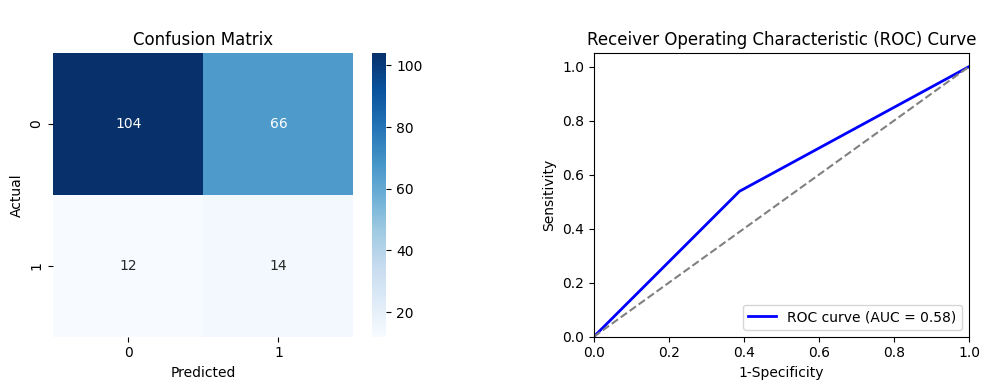

In [267]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=50, 
                                  random_state=42, 
                                  min_samples_split=4, 
                                  min_samples_leaf=5, 
                                  max_features=7, 
                                  criterion='gini',
                                 class_weight = {0:1, 1:2})
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
cm2 = plot_roc_curve_and_confusion_matrix(y_test, y_pred_rf)

In [268]:
calculate_metrics_from_confusion_matrix(cm2)

,Metric,Score
0,Accuracy,0.602041
1,Precision,0.175000
2,Recall,0.538462
3,F1-score,0.264151


In [308]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid with more regularization options
param_grid = {
    'n_estimators': [10, 30, 50, 70],
    'max_features': [1, 2, 3, 4, 5, 6, 7, 8], 
    'max_depth': [None, 5, 7, 10, 16],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'class_weight': [{0:1, 1:2}, {0:1, 1:3}, {0:1, 1:4}, 'balanced', 'balanced_subsample'],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3],
    'max_leaf_nodes': [None, 10, 20, 30, 40, 50],
    'min_impurity_decrease': [0.0, 0.1, 0.2, 0.3],
    'random_state': [0, 1, 2, 40, 42]
}

rf = RandomForestClassifier()

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100,
                                   scoring='f1', cv=4, verbose=1, n_jobs=-1)

random_search.fit(X_train, y_train)
best_params = random_search.best_params_
# Print the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best accuracy score: {:.2f}".format(random_search.best_score_))

Fitting 4 folds for each of 100 candidates, totalling 400 fits
Best parameters found:  {'random_state': 40, 'n_estimators': 30, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 10, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 20, 'max_features': 2, 'max_depth': None, 'criterion': 'entropy', 'class_weight': {0: 1, 1: 4}, 'bootstrap': False}
Best accuracy score: 0.43


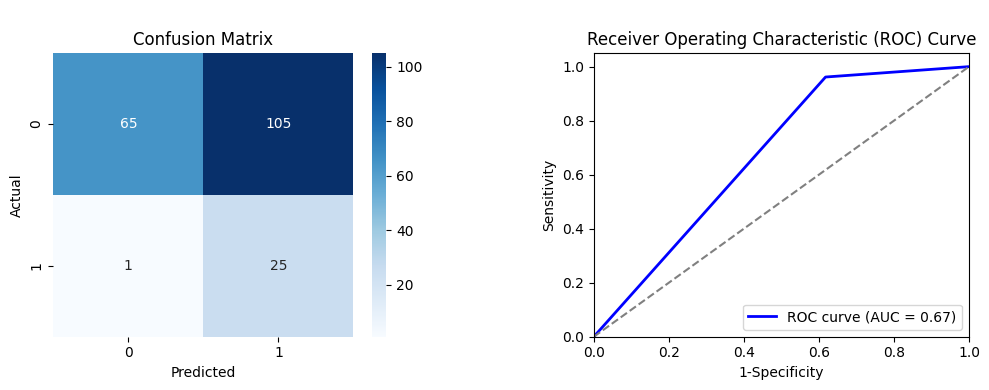

In [309]:
rf_model2 = RandomForestClassifier(**best_params)

# Fit the model to the training data
rf_model2.fit(X_train, y_train)
y_pred_rf2 = rf_model2.predict(X_test)
cm5 = plot_roc_curve_and_confusion_matrix(y_test, y_pred_rf2)

In [310]:
calculate_metrics_from_confusion_matrix(cm5)

,Metric,Score
0,Accuracy,0.459184
1,Precision,0.192308
2,Recall,0.961538
3,F1-score,0.320513


In [323]:
X_test_with_predictions = X_test.copy()
X_test_with_predictions['True Label'] = y_test
X_test_with_predictions['Predicted Label'] = y_pred_rf2

misclassified = X_test_with_predictions[X_test_with_predictions['True Label'] != X_test_with_predictions['Predicted Label']]
print("Misclassified Observations:")
misclassified

Misclassified Observations:


,MotorCurrent,Frequency,PIP,TubingPressure,CasingPressure,PIT,MotorTemperature,XVib,True Label,Predicted Label
422,24.544823,57.997790,361.599747,130.823548,218.729167,237.454861,259.000000,2.461490,0,1
430,25.267677,58.190025,346.111742,137.028409,260.576389,235.351010,256.987689,2.831755,0,1
431,23.411616,57.535038,374.927399,113.162563,192.338384,240.954861,261.754104,2.867424,0,1
432,23.472538,57.599747,392.423611,116.768308,195.341856,240.756313,261.887942,2.794823,0,1
441,23.843750,56.968750,366.614583,121.479167,239.059028,243.079861,263.562500,3.052083,0,1
...,...,...,...,...,...,...,...,...,...,...
695,28.560259,56.566436,969.360543,157.172980,95.094066,259.578914,282.470013,6.409091,0,1
696,28.471528,56.078586,970.293371,155.972222,96.484848,260.073864,283.189710,6.333333,0,1
697,28.305240,55.713709,974.141446,152.827652,97.950126,260.883838,284.016098,6.407828,0,1
698,28.431250,55.747986,974.885069,155.840278,96.465278,260.263889,283.121528,6.468750,0,1


In [324]:
df_test[-15:]

,NodeID,Date,MotorCurrent,Frequency,PIP,TubingPressure,CasingPressure,PIT,MotorTemperature,XVib,Label
697,7,2020-06-12,28.305240,55.713709,974.141446,152.827652,97.950126,260.883838,284.016098,6.407828,0
698,7,2020-06-13,28.431250,55.747986,974.885069,155.840278,96.465278,260.263889,283.121528,6.468750,0
699,7,2020-06-14,28.479072,55.996509,971.512083,154.411237,96.822348,260.690088,283.779040,6.501073,1
700,7,2020-06-15,28.757162,56.428048,970.016379,186.820802,123.011620,259.501804,282.350276,6.532926,1
701,7,2020-06-16,28.317551,56.675436,976.619318,172.302083,124.222538,261.881944,284.590909,6.503472,1
702,7,2020-06-17,28.724653,56.173854,976.470139,179.107639,125.538194,260.180556,282.579861,6.510417,1
703,7,2020-06-18,28.435859,55.917244,971.997254,172.350379,124.560606,260.261995,283.082386,6.440657,1
704,7,2020-06-19,28.427999,56.247822,975.864426,176.130997,125.054293,260.259785,282.453914,6.363321,1
705,7,2020-06-20,28.545297,56.000281,969.368845,183.772727,125.027778,258.248422,281.063131,6.506629,1
706,7,2020-06-21,28.845581,53.606922,958.673706,179.808081,113.785354,248.904356,270.354798,5.211806,1


In [325]:
daily_df[daily_df.NodeID == 7][-15:]

,NodeID,Date,MotorCurrent,Frequency,PIP,TubingPressure,CasingPressure,PIT,MotorTemperature,XVib,Label
697,7,2020-06-12,28.305240,55.713709,974.141446,152.827652,97.950126,260.883838,284.016098,6.407828,0.0
698,7,2020-06-13,28.431250,55.747986,974.885069,155.840278,96.465278,260.263889,283.121528,6.468750,0.0
699,7,2020-06-14,28.479072,55.996509,971.512083,154.411237,96.822348,260.690088,283.779040,6.501073,0.0
700,7,2020-06-15,28.757162,56.428048,970.016379,186.820802,123.011620,259.501804,282.350276,6.532926,0.0
701,7,2020-06-16,28.317551,56.675436,976.619318,172.302083,124.222538,261.881944,284.590909,6.503472,0.0
702,7,2020-06-17,28.724653,56.173854,976.470139,179.107639,125.538194,260.180556,282.579861,6.510417,0.0
703,7,2020-06-18,28.435859,55.917244,971.997254,172.350379,124.560606,260.261995,283.082386,6.440657,0.0
704,7,2020-06-19,28.427999,56.247822,975.864426,176.130997,125.054293,260.259785,282.453914,6.363321,1.0
705,7,2020-06-20,28.545297,56.000281,969.368845,183.772727,125.027778,258.248422,281.063131,6.506629,1.0
706,7,2020-06-21,28.845581,53.606922,958.673706,179.808081,113.785354,248.904356,270.354798,5.211806,1.0


### $\textbf{XGboost}$

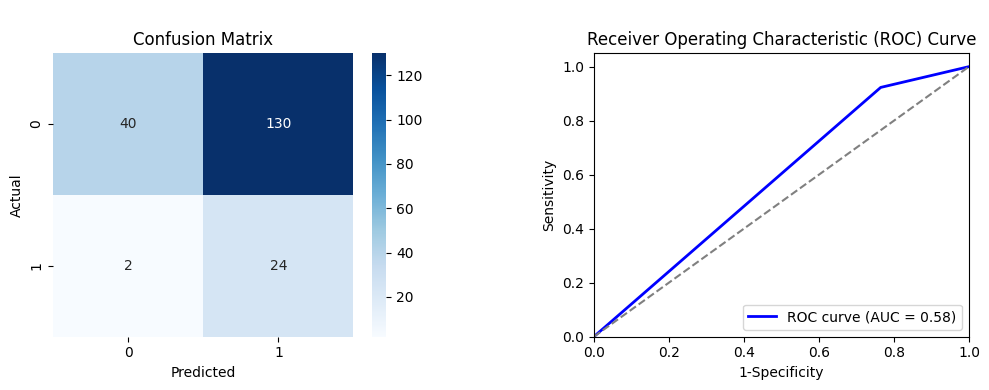

In [241]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=50,
    max_depth=10,
    learning_rate=0.9,
    subsample=0.9,
    colsample_bytree=1.0,
    gamma=0,
    random_state=40,
    scale_pos_weight=2,
    min_child_weight=10,
    reg_alpha=0.1, 
    reg_lambda=0.1
)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
cm3 = plot_roc_curve_and_confusion_matrix(y_test, y_pred_xgb)

In [242]:
calculate_metrics_from_confusion_matrix(cm3)

,Metric,Score
0,Accuracy,0.326531
1,Precision,0.155844
2,Recall,0.923077
3,F1-score,0.266667


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [1, 2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_child_weight': [1, 2, 3, 4, 5],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.5, 1.0, 1.5, 2.0],
    'scale_pos_weight': [1, 2, 3, 4, 5],
    'random_state': [0, 1, 2, 42]
}

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='f1', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best F1 score: {:.2f}".format(best_score))

Fitting 5 folds for each of 36000000 candidates, totalling 180000000 fits


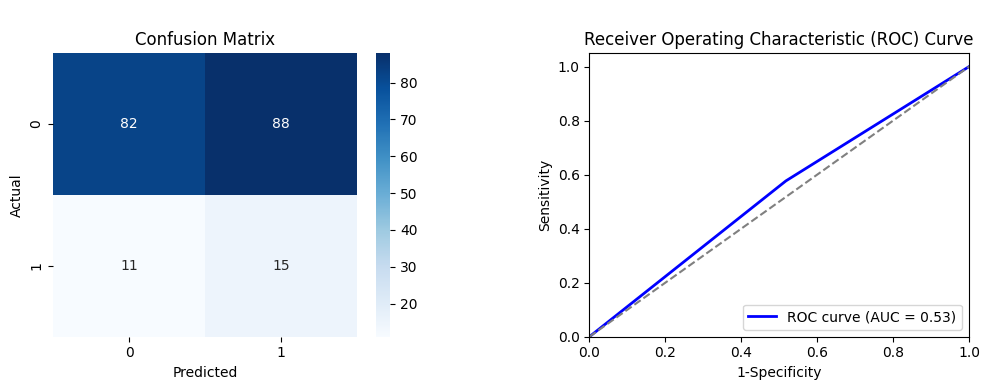

In [359]:
xgb_clf_best = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    min_child_weight=best_params['min_child_weight'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    scale_pos_weight=best_params['scale_pos_weight'],
    random_state=best_params['random_state']
)

xgb_clf_best.fit(X_train, y_train)

y_pred_xgb2 = xgb_clf_best.predict(X_test)
cm6 = plot_roc_curve_and_confusion_matrix(y_test, y_pred_xgb2)

In [355]:
calculate_metrics_from_confusion_matrix(cm6)

,Metric,Score
0,Accuracy,0.642857
1,Precision,0.185714
2,Recall,0.500000
3,F1-score,0.270833
